In [1]:
#setup
data_dir='../../Data/Weather'
file_index='BBBSBBBB'
meas='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|  339.0635112910323|-81.46986975964708|   184.018851626029|     27.4|BBBSBBBB| 42.5947| -71.0208|       PRCP|0.9618258099737336|  0.95949581902466|0.9481310954035469|0.8759618401510856|USC00194744|3429166.0|     1|[00 00 00 00 00 0...|1998.0|
| -132.4257567717023|-34

### Plot Mean and Eigenvecs

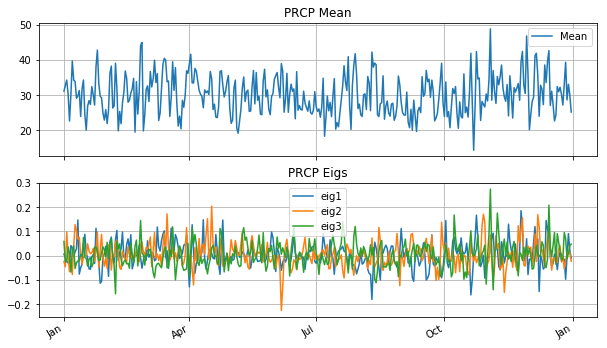

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

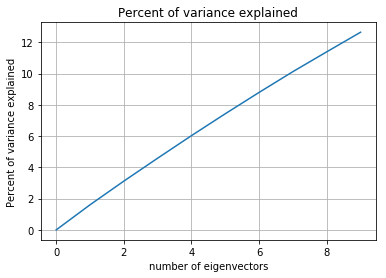

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

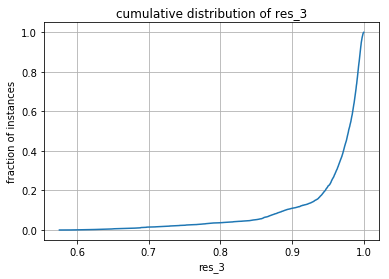

In [10]:
plot_CDF(df,'res_3')

In [10]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00194744', 1998.0)

In [11]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

46720

In [12]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [13]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [14]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00192812 354
USC00193890 9946
USC00192150 5436
USW00014753 43051
USC00191622 16248
USC00193224 1459
USC00194360 2804
USC00193229 2488
USC00198580 26731
USC00198793 24309
USC00194125 999
USC00190593 5723
USC00190595 1072
USC00191344 1418
USC00196699 14430
USC00192806 29192
USC00190535 18495
USC00190538 6867
USC00191323 1091
USC00198757 14530
US1MAWR0001 1312
USC00198755 8379
USC00199226 3941
USC00197104 3209
USC00190801 20452
USC00190120 40335
USC00196915 5694
USC00193625 10556
USC00193624 18877
USC00194135 14966
USC00199093 332
USC00198218 364
USC00193429 354
USC00196993 2386
USC00195060 1813
USC00195390 4218
US1MAWR0013 365
USW00094746 23318
USC00190582 680
USC00198030 24771
USW00014739 28077
USC00195095 4304
USW00054756 5036
USC00193940 705
USC00195177 318
USC00195524 17383
USC00194502 10158
US1MAES0008 1070
USC00195077 365
USC00198301 9296
USC00190551 18723
USC00195175 11931
US1MAES0002 1041
USC00199080 10218
USC00194760 25782
USC00191097 6520
USC00192107 18125
USC00194154 725
US

In [15]:
len(All)

140

In [17]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(140, 46720)


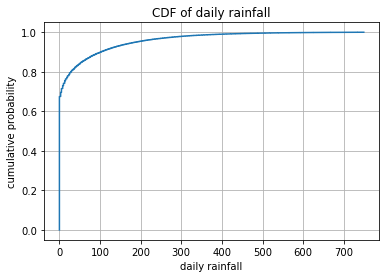

In [18]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

In [22]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    return -G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
exp(LogProb(100,20,50,50))

0.022015393458583134

In [23]:
#USC00193270 21482
#USC00193702 28237
X=copy(All['USC00193270'])
Y=copy(All['USC00193702'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


21482
28237
16659
16659


In [28]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    m=sum(~np.isnan(X))
    n1=nansum(X>0)
    n2=nansum(Y>0)
    l=nansum(X*Y>0)
    answer=LogProb(m,l,n1,n2)
    #print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,answer)
    return answer
print computeLogProb(X,Y)

-53.2486920164


/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


In [30]:
L=len(Stations)
Pvals=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        Pvals[i,j]=computeLogProb(X,Y)

            

0 1 2

/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139


In [46]:
Pvals[-10:,-10:]/-1000

array([[-0.        ,  2.01739012,  4.29205597,  3.09088751,  1.71084926,
         1.45290385,  1.50268629,  1.06456136, -0.        ,  3.80096204],
       [ 2.01739012, -0.        ,  2.45815015,  2.02400121,  1.29773004,
         0.06201505,  0.07160111,  0.06536799, -0.        ,  2.43247507],
       [ 4.29205597,  2.45815015, -0.        ,  9.45189299,  5.22381378,
         1.7806281 ,  1.54597925,  1.00460894, -0.        ,  7.4865932 ],
       [ 3.09088751,  2.02400121,  9.45189299, -0.        ,  5.3893621 ,
         1.18340876,  0.895329  ,  0.58837865,  4.51000482,  6.27866149],
       [ 1.71084926,  1.29773004,  5.22381378,  5.3893621 , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  4.11273507],
       [ 1.45290385,  0.06201505,  1.7806281 ,  1.18340876, -0.        ,
        -0.        ,  1.35947931,  0.98302961, -0.        ,  1.52688711],
       [ 1.50268629,  0.07160111,  1.54597925,  0.895329  , -0.        ,
         1.35947931, -0.        ,  0.88868938

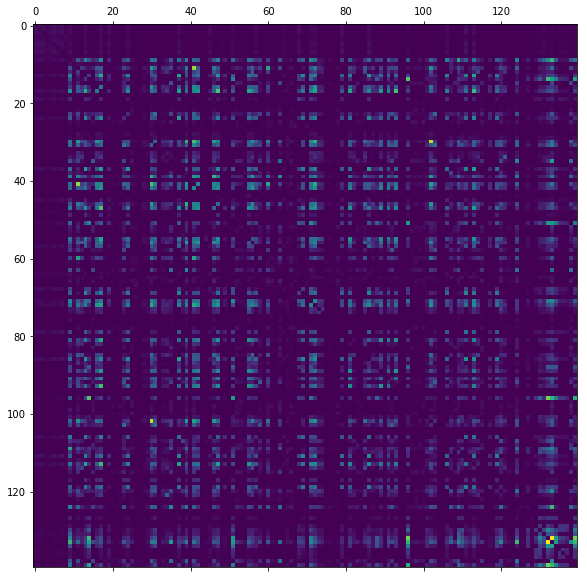

In [57]:
showmat(Pvals/-500)

In [33]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


total RMS                   =  83.7391803037
RMS removing mean-by-station=  78.1284392295
RMS removing mean-by-day   =  50.0713518004


In [21]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(tbl_minus_day**2,axis=1))
NRT=(tbl_minus_day.transpose()/Len).transpose()

In [22]:
K=5  # the number of time-shifts we consider
Middle=K/2 # the index (among K) of the zero-time-shift
n,m=RT.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)

#create the shifts
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

#zero Nan entries and indicate them in a separate matrix
TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print 'shape of sequence matrix (TT) %s, shape of matrix with %d shifts (TK) %s'%\
    (str(TT.shape),K,str(TK.shape))
#print sum(TK1nan,axis=1)
#print sum(TT1nan)

shape of sequence matrix (TT) (140, 46715), shape of matrix with 5 shifts (TK) (700, 46715)


In [23]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

(700, 140)
0


In [24]:
n,m

(140, 46720)

In [52]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=np.argmax(Slice,axis=0)  #find best shift
    _max[i,:]=np.max(Slice,axis=0) #find max correlation

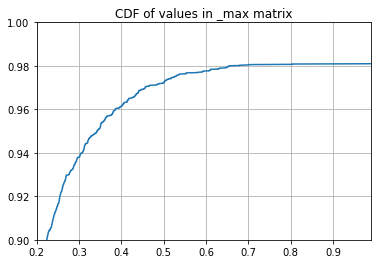

In [53]:
Values=_max[_max>0.01].flatten()
Values=sorted(Values)
len(Values),len(arange(0,1,1./len(Values)))
plot(Values,arange(0,1,1./len(Values)))
xlim([0.2,0.99])
ylim([0.9,1])
grid()
title('CDF of values in _max matrix');

In [35]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

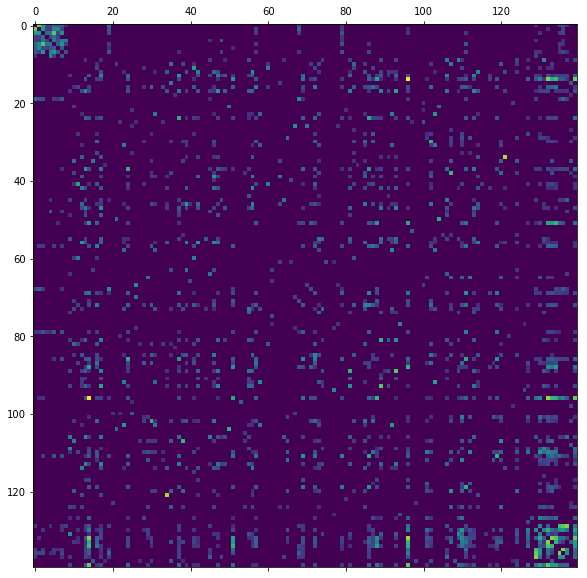

In [60]:
_max2=np.array(_max)
_max2[_max>0.99]=0.
_max2[_max<0.1]=0.
showmat(_max2)

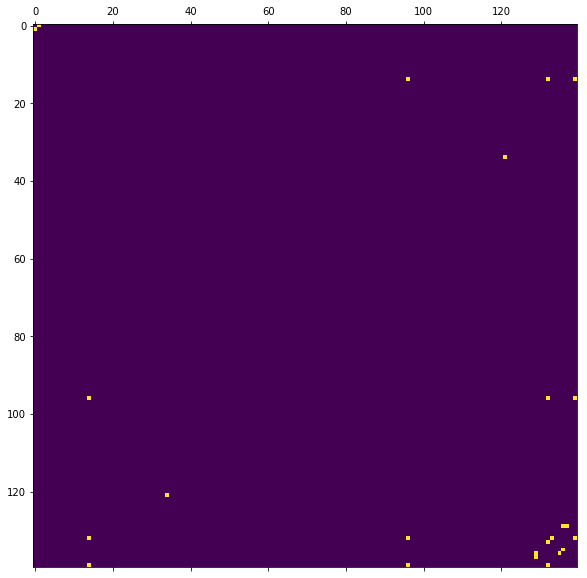

In [29]:
_Sshift=_shift*(_max2>0.01)
showmat(_Sshift)

In [70]:
L=np.nonzero(Pvals<-1000)
_corr=Pvals[L]
matches=[]
for i in range(len(_corr)):
    item={'station0':Stations[L[0][i]],
          'station1':Stations[L[1][i]],
          'correlation':_corr[i]}
    matches.append(item)
matches[:4]

[{'correlation': -2477.3322940648941,
  'station0': u'USC00190120',
  'station1': u'USC00190218'},
 {'correlation': -1056.8980787112232,
  'station0': u'USC00190120',
  'station1': u'USC00190257'},
 {'correlation': -4186.6318753289961,
  'station0': u'USC00190120',
  'station1': u'USC00190408'},
 {'correlation': -2519.8477777933149,
  'station0': u'USC00190120',
  'station1': u'USC00190535'}]

In [71]:
import pickle
stations_df = pickle.load(open(data_dir+'/stations.pkl','r'))

In [72]:
for record in matches:
    _st0 = stations_df.loc[record['station0']]
    record['latitude0']=_st0['latitude']
    record['longitude0']=_st0['longitude']
    _st1 = stations_df.loc[record['station1']]
    record['latitude1']=_st1['latitude']
    record['longitude1']=_st1['longitude']
print len(matches)
matches[-1:]

2402


[{'correlation': -1226.9307383009618,
  'latitude0': 42.270600000000002,
  'latitude1': 42.57,
  'longitude0': -71.873099999999994,
  'longitude1': -72.2911,
  'station0': u'USW00094746',
  'station1': u'USW00054756'}]

In [73]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [50]:
#print min(_Sshift.flatten()),max(_Sshift.flatten())

NameError: name '_Sshift' is not defined

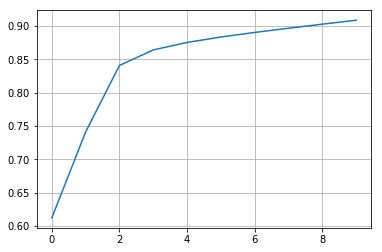

In [74]:
from sklearn.decomposition import PCA
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(Pvals)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(cumsum(Var_explained))
grid()

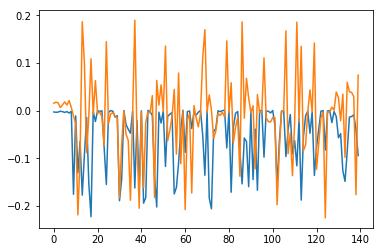

In [75]:
comp=pca.components_.transpose()
plot(comp[:,:2])

In [76]:
records=[]
for i in range(len(Stations)):
    _st=Stations[i]
    row=stations_df.loc[_st]
    item={'station':_st,
          'components':comp[i,:],
          'longitude':row['longitude'],
          'latitude':row['latitude']}
    records.append(item)
records[:2]

[{'components': array([-0.00291946,  0.01537101,  0.00065883, -0.01710533, -0.00185543,
          0.03099425, -0.00121004, -0.00204696, -0.00495337,  0.00018177]),
  'latitude': 42.587200000000003,
  'longitude': -70.877399999999994,
  'station': u'US1MAES0002'},
 {'components': array([-0.00361412,  0.01770321, -0.00110859, -0.01815327, -0.00295801,
          0.03516011, -0.00160476, -0.00312006, -0.00744809,  0.00104282]),
  'latitude': 42.492100000000001,
  'longitude': -70.875799999999998,
  'station': u'US1MAES0008'}]

In [77]:
import pylab as plt
from matplotlib.colors import rgb2hex
cmap=plt.get_cmap('Accent')
def get_color(val):
    return(rgb2hex(cmap(float(val)/8)[:3]))

for i in range(8):
    print get_color(i)

#7fc97f
#beaed4
#fdc086
#ffff99
#386cb0
#f0027f
#bf5b17
#666666


In [54]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
_map = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=1, fill_opacity=0.0)
_map += r
lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4

color_i=0
KK=10;
for i in range(n_comp):
    records.sort(key=lambda X:X['components'][i])
    for edge in [-1,+1]:
        if edge==-1:
            _list=records[:KK]
        else:
            _list=records[-KK:]
        for r in _list:
            _lat=r['latitude']
            _long=r['longitude']
            c = Circle(location=(_lat,_long), radius=int(3000), weight=1,
                        color='#F00', opacity=0.8, fill_opacity=0.4,
                        fill_color=get_color(color_i))
        _map+=c
        color_i+=1
_map

NameError: name 'records' is not defined

In [55]:
min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
_map = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=1, fill_opacity=0.0)
_map += r
lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4

color_i=0
for i in [1]:
    records.sort(key=lambda X:X['components'][i])
    print records[:2]
    for edge in [+1,-1]:
        if edge==-1:
            _list=[] #records[:40]
        else:
            _list=records[115:]
        for r in _list:
            _lat=r['latitude']
            _long=r['longitude']
            c = Circle(location=(_lat,_long), radius=int(3000), weight=1,
                        color='#F00', opacity=0.8, fill_opacity=0.4,
                        fill_color=get_color(color_i))
            _map+=c
        color_i+=1
_map

NameError: name 'records' is not defined

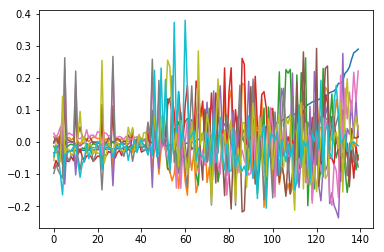

In [42]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);


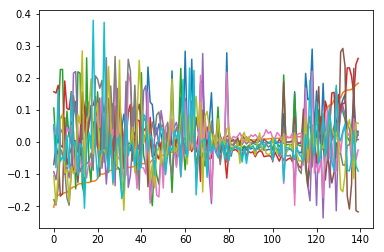

In [43]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[1]) 
plot(X);


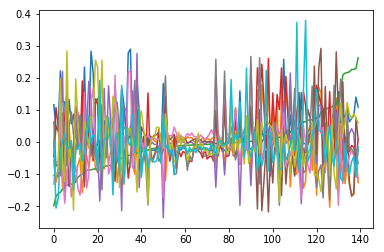

In [44]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[2]) 
plot(X);


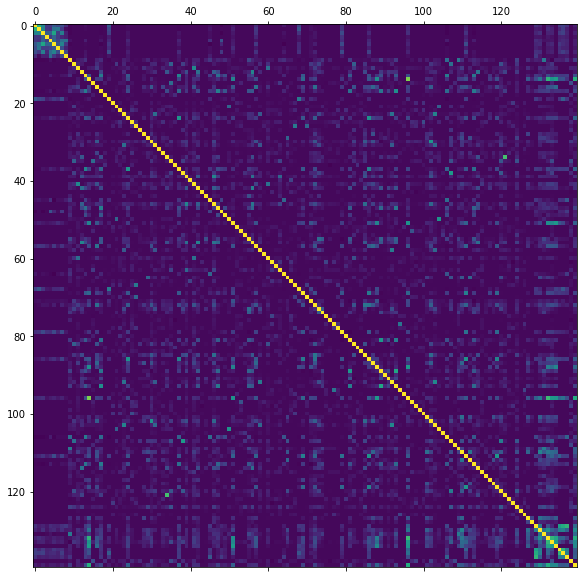

In [51]:
order=np.argsort(pca.components_[0,:])
_max_reord=_max[order,:]
_max_reord=_max_reord[:,order]
_max2=_max_reord
_max2[_max2>9]=0.
_max2[_max2<2]=0.
showmat(_max)

In [ ]:
comp_=pca.components_
figure(figsize=(10,10))
print shape(comp_)
scatter(comp_[0,:],comp_[1,:]);